# Communication Subspaces
We consider two recurrently connected circuits $1$ and $2$ described by the equations

$$\begin{align*}
\displaystyle \tau \frac{d\mathbf{x}_1}{dt} 
&= -\mathbf{x}_1 + W_{11}\mathbf{x}_1 + W_{12}\mathbf{x}_2 \\
\displaystyle \tau \frac{d\mathbf{x}_2}{dt} 
&= -\mathbf{x}_2 + W_{22}\mathbf{x}_2 + W_{21}\mathbf{x}_1
\end{align*}$$

- $\tau$: membrane time constant
- $\mathbf{x}_1 \in \mathbb{R}^{n_1}$: neuronal activity vector of circuit 1
- $\mathbf{x}_2 \in \mathbb{R}^{n_1}$: neuronal activity vector of circuit 1
- $W_{11} \in \mathbb{R}^{n_1 \times n_1}$: synaptic connectivity matrix of circuit 1
- $W_{22} \in \mathbb{R}^{n_2 \times n_2}$: synaptic connectivity matrix of circuit 2
- $W_{12} \in \mathbb{R}^{n_2 \times n_2}$: synaptic projection matrix from circuit 2 to circuit 1
- $W_{21} \in \mathbb{R}^{n_2 \times n_2}$: synaptic projection matrix from circuit 1 to circuit 2

For this dynamical system, we ask
- can we find strong patterns of activity in circuit 1 that evoke strong responses in circuit 2?
- can we find strong patterns of activity in circuit 1 that evoke weak responses in circuit 2?

We begin by defining a new state 
$$\mathbf{x}(t) = \big ( \mathbf{x}_1(t)^T \quad \mathbf{x}_2(t)^T \big )^T,$$
which evolves according to
$$\begin{align*}
    \displaystyle \frac{d\mathbf{x}}{dt} &= A\mathbf{x} + B\mathbf{u}\\
    \mathbf{y}_1 &= C_1\mathbf{x}_1\\
    \mathbf{y}_2 &= C_2\mathbf{x}_2,
\end{align*}$$
where 
$$\begin{align*}
    A &= \frac{1}{\tau} \bigg ( \begin{array}{cc}
    I_{n_1 \times n_1} - W_{11} & W_{12} \\
    W_{21} & I_{n_2 \times n_2} - W_{22}
    \end{array} \bigg ),\\
    B &= \frac{1}{\tau} \big (I_{n_1 \times n_1} \quad 0_{n_1 \times n_2} \big )^T,\\
    C_1 &= \big ( I_{n_1 \times n_1} \quad 0_{n_1 \times n_2} \big ),\\
    C_2 &= \big ( 0_{n_2 \times n_1} \quad 0_{n_2 \times n_2} \big ).
\end{align*}$$

We choose $C_1$, $C_2$, and $B$ such that 

- $\mathbf{y}_1 = \mathbf{x}_1$,
- $\mathbf{y}_2 = \mathbf{x}_2$, and
- impulses $\mathbf{u}(t) = \delta(t)\mathbf{h}$ are only delivered to circuit 1.

It is useful to define the observability Gramians
$$\begin{align*}
    Q_1 &= \displaystyle \int_0^\infty e^{A^Tt} C_1^T C_1 e^{At} dt,\\
    Q_2 &= \displaystyle \int_0^\infty e^{A^Tt} C_2^T C_2 e^{At} dt.
\end{align*}$$

The total energy evoked in network $1$ for some $\mathbf{h}$ is given by $\mathbf{h}^TB^T Q_1 B\mathbf{h}$. Therefore, the $\mathbf{h}$ that maximises the response in circuit $1$ lies in the top subspace of $B^TQ_1B$.

We thus parameterise $\mathbf{h}$ as 
$$\mathbf{h} = Z\bar{\mathbf{h}},$$
where the columns are $Z \in \mathbb{R}^{n \times p}$ are the top $p$ eigenvectors of $B^TQ_1B$.

Given such a paramterisation, the output energy in network 2 is 

$$\bar{\mathbf{h}}^T Z^T Q_2 Z \bar{\mathbf{h}}.$$

### Communication null
If we choose $\bar{\mathbf{h}}$ to be in the bottom subspace of $Z^TQ_2Z$, 
we get 
- strong response in network 1 and
- weak response in network 2.

### Communication potent
On the contrary, if we choose $\bar{\mathbf{h}}$ to be in the top subspace of $Z^TQ_2Z$, 
we get 
- strong response in network 1 and
- strong response in network 2.
 

In [1]:
#use "./init.ml"
open Owl
open Printf
open Noc

In [2]:
(* network connectivity matrix *)
let w = Mat.load_txt "../data/w"
(* number of neurons in the network *)
let n, _ = Mat.shape w
(* A matrix *)
let a = Mat.(w - eye n)
(* time constant *)
let tau = 20E-3
let simulate = Simulate.impulse ~tau ~n ~a

val w : Owl.Mat.mat = ...


val n : int = ...


val a : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val tau : float = ...


val simulate : ?c:Owl.Mat.mat -> input:Owl.Mat.mat -> float -> Owl.Mat.mat =
  ...


In [3]:
(* ------- dynamical nullspace ------ *)
(* pick initial conditions such that the first n1=20 neurons
 * remain unmodulated while the other neurons are maximally modulated *)
let n1 = 20
let n2 = 180
(* some generic things *)
let c = Mat.((eye n).${[[0; pred n1]; []]})
let q = Gramians.obsv ~c a
(* potent subspace *)
let communication_potent =
  let z = Mat.((eye n).${[[]; [n1; -1]]}) in
  let ztqz = Mat.((transpose z) *@ q *@ z) in
  let u, _, _ = Linalg.D.svd ztqz in
  let ut = Mat.transpose Mat.(z *@ u) in
  let ut = Mat.(ut / l2norm ~axis:1 ut) in
  Mat.save_txt Mat.(transpose ut) "potent_u";
  simulate ~input:Mat.(row ut 0) 0.3 

(* dynamical nullspace: top subspace of Z^T Q Z, with Z hitting the top
   obs subspace of network 1 *)
let communication_null =
  let b =
    let z = Mat.((eye n).${[[]; [n1; -1]]}) in
    let zt = Mat.transpose z in
    let c = Mat.((eye n).${[[n1; -1]; []]}) in
    let q = Gramians.obsv ~c a in
    let ztqz = Mat.(zt *@ q *@ z) in
    let u, _, _ = Linalg.D.svd ztqz in
    let u = Mat.(z *@ u) in
    let u = Mat.(u / l2norm ~axis:0 u) in
    Mat.(u.${[[]; [0; 25]]})
  in
  let bt = Mat.transpose b in
  let btqb = Mat.(bt *@ q *@ b) in
  let u, _, _ = Linalg.D.svd btqb in
  let ut = Mat.transpose Mat.(b *@ u) in
  let ut = Mat.(ut / l2norm ~axis:1 ut) in
  Mat.save_txt Mat.(transpose ut) "null_u";
  simulate ~input:Mat.(row ut (-1)) 0.3

val n1 : int = ...


val n2 : int = ...


val c : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val q : Owl.Mat.mat = ...


val communication_potent : Owl.Mat.mat = ...


val communication_null : Owl.Mat.mat = ...


### 3.3 Plotting the communication potent and null  subspaces

We plot the activities evoked in network 1 (right, pink) and 2 (left, black) by
impulses that maximises (top, potent) and minimises (bottom, null) response in network 2.

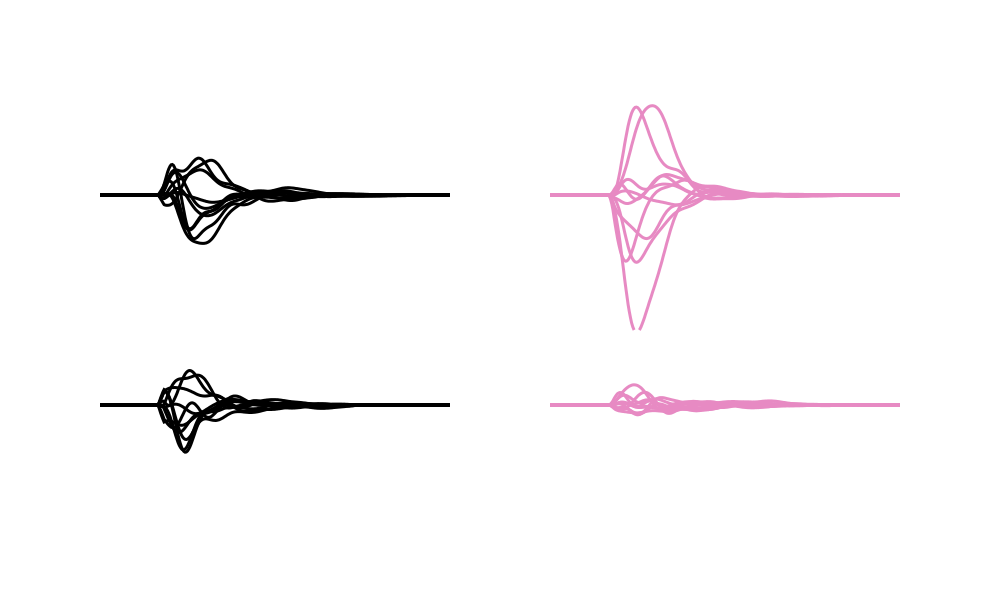

In [4]:
let () =
      let open Gp in
      let display_id = Jupyter_notebook.display "text/html" "" in
      let potent_2 =  
          List.init (n1/2) (fun i -> item (A communication_potent) 
              ~using:(sprintf "1:%i" (2*i+2)) ~style:"l lw 3 lc rgb '#e78ac3'") in
      let null_2 =  
          List.init (n1/2) (fun i -> item (A communication_null) 
              ~using:(sprintf "1:%i" (2*i+2)) ~style:"l lw 3 lc rgb '#e78ac3'") in
      let potent_1 =  
          List.init (n1/2) (fun i -> item (A communication_potent) 
              ~using:(sprintf "1:%i" (n1+2*i+2)) ~style:"l lw 3 lc black") in
      let null_1 =  
          List.init (n1/2) (fun i -> item (A communication_null) 
              ~using:(sprintf "1:%i" (n1+2*i+2)) ~style:"l lw 3 lc black") in
      let items = [|potent_1; potent_2; null_1; null_2|] in
      let figure (module P: Plot) = 
          P.multiplot ~spacing:(0.1,-0.1) (2,2) (fun k _ _ ->
          P.plots items.(k)
          [  barebone ; yrange (-0.3,0.3); ] 
          ) in
      Juplot.draw ~display_id ~size:(1000,600) figure